# Отток клиентов

**Цель:** Анализ оттока клиентов из "Бета-Банка" и создание модели, определяющей, уйдет клиент или нет.


**Задачи:** Построение модели с предельно болшим значением F1-меры и лучшим значением AUC-ROC на основе данных о поведении клиентов и расторжении договоров с банком


**Источник данных:** [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных

**Признаки**

RowNumber — индекс строки в данных

CustomerId — уникальный идентификатор клиента

Surname — фамилия

CreditScore — кредитный рейтинг

Geography — страна проживания

Gender — пол

Age — возраст

Tenure — сколько лет человек является клиентом банка

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты

IsActiveMember — активность клиента

EstimatedSalary — предполагаемая зарплата

**Целевой признак**

Exited — факт ухода клиента

## Подготовка данных



### Открытие данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
#импортируем нужные библиотеки для работы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report

from tqdm import tqdm
import warnings

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


import sklearn.metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier



In [3]:
#прочитаем данные
data = pd.read_csv('C:/Users/Lerusik/Documents/datasets/Churn.csv', sep=',')
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


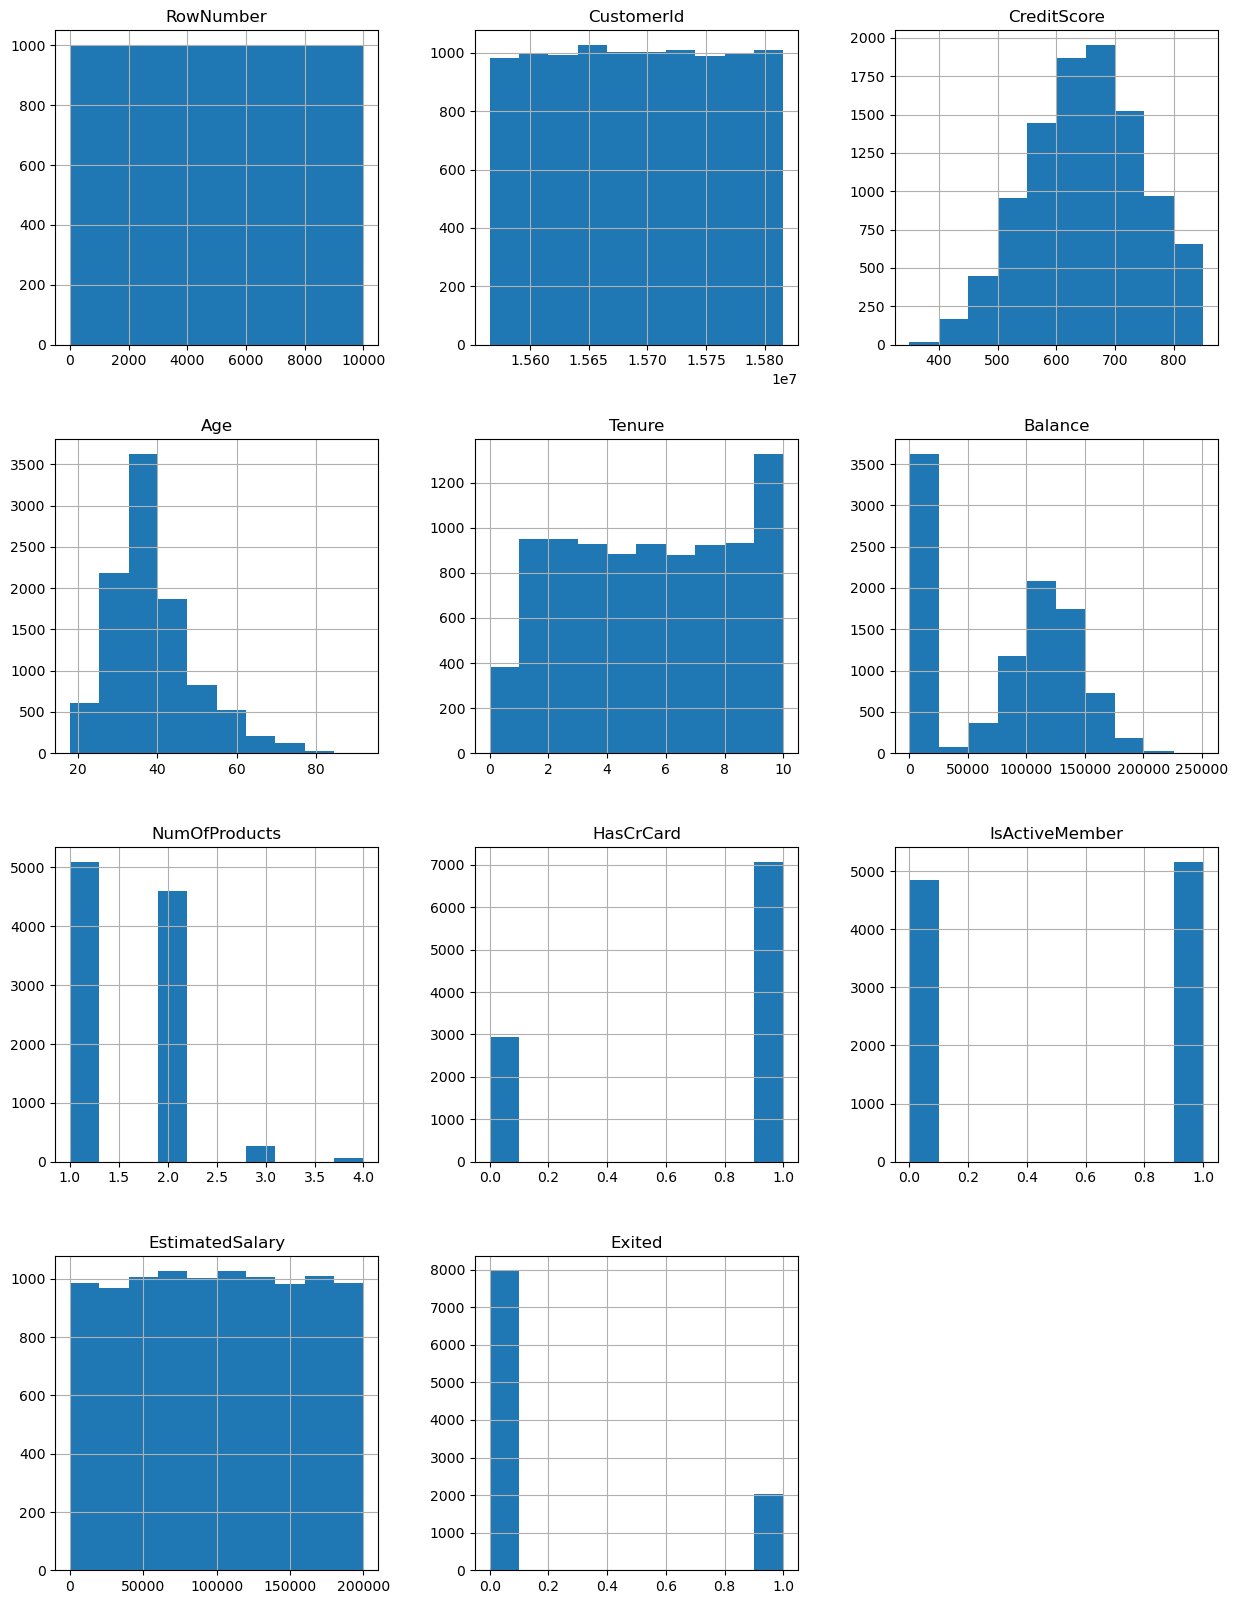

In [4]:
#получим гистограммы по всем столбцам
data.hist(figsize=(15, 20))
plt.show()

По гистограмме выбросов сильных не вижу(да, лучше их проверить графиками выбросов, я проверяла уникальными значениями, всё норм, но не хочу этим проект заполнять)

### Корреляции между признаками 

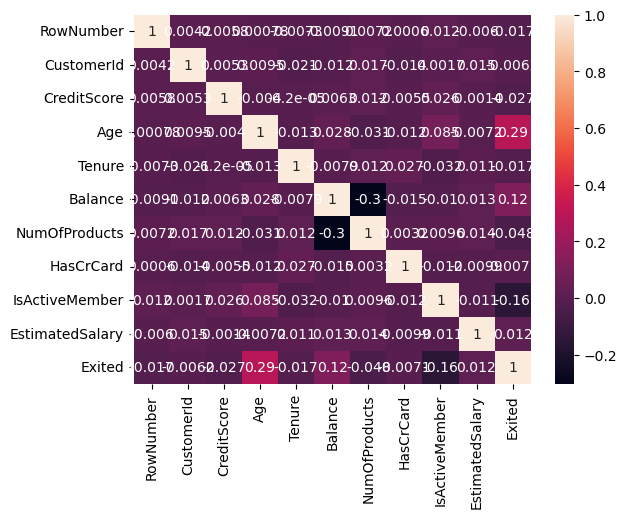

In [5]:
sns.heatmap(data.corr(), annot = True) #посмотрим корреляции Пирсона
plt.show()

interval columns not set, guessing: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


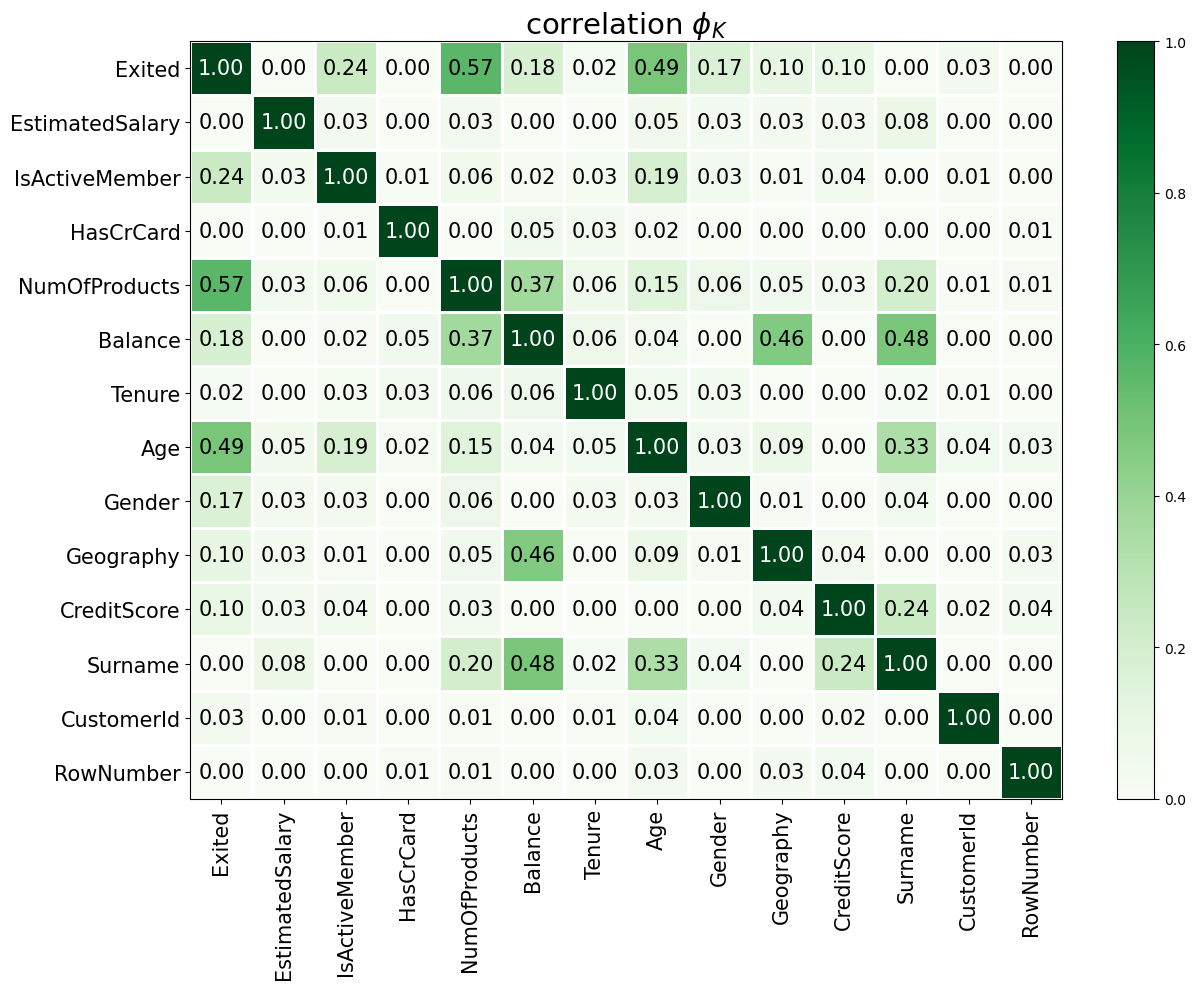

In [6]:
warnings.filterwarnings("ignore")

phik_overview = data.phik_matrix()
phik_overview.round(1)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(13, 10))
plt.tight_layout()

### Проверка на пропуски

In [7]:
#получим общую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Видно, что в столбце Tenure(сколько лет человек является клиентом банка) есть пропуски. Их незначительное количество(909 шт). Вероятно, они связаны с потерей информации из-за технических сложностей, например, из-за перевыпуска карт или из-за технических причин сбора информации для этой таблицы.

Попробуем посмотреть возраст людей, где есть пропуск в Tenure. Если где-то есть зависимость, то доставим данные.

In [8]:
data[data['Tenure'].isna()]['Age'].unique()

array([39, 38, 36, 41, 35, 75, 42, 34, 48, 29, 49, 30, 45, 33, 37, 43, 28,
       31, 57, 26, 59, 25, 46, 32, 40, 70, 54, 44, 27, 58, 21, 52, 62, 74,
       61, 22, 55, 71, 56, 18, 23, 65, 24, 50, 51, 47, 63, 60, 67, 53, 66,
       20, 64, 78, 19, 68, 72, 92], dtype=int64)

In [9]:
#посмотрим, каких данных много, какими можно заполнить пропуски
data[(data['Age'] > 20)   & (data['Age'] < 50)]['Age'].value_counts()

37    478
38    477
35    474
36    456
34    447
33    442
40    432
39    423
32    418
31    404
41    366
29    348
30    327
42    321
43    297
28    273
44    257
45    229
46    226
27    209
26    200
47    175
48    168
25    154
49    147
24    132
23     99
22     84
21     53
Name: Age, dtype: int64

In [10]:
tenure_from_age_plot = data.pivot_table(index='Age', values='Tenure', aggfunc=['median', 'min', 'max'])
tenure_from_age_plot

,median,min,max
,Tenure,Tenure,Tenure
Age,,,
18,4.5,1.0,10.0
19,5.0,0.0,9.0
20,4.0,0.0,10.0
21,4.0,0.0,10.0
22,6.0,0.0,10.0
...,...,...,...
83,6.0,6.0,6.0
84,8.0,8.0,8.0


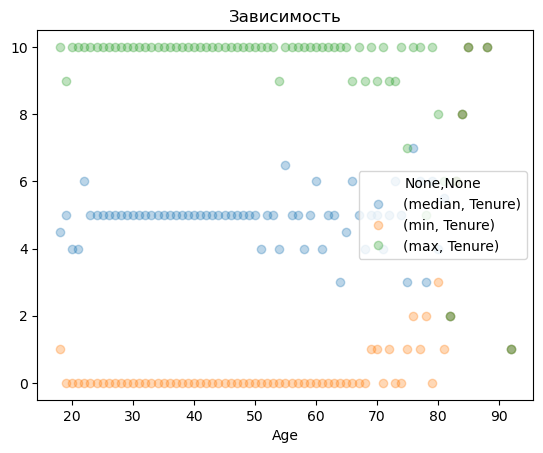

In [11]:
tenure_from_age_plot.plot(title='Зависимость', style='o',alpha=0.3)
plt.show()

Видно, что зависимости от возраста нет. Странно, что среднее колеблется около 5 лет. Вероятно, банк выпустил удобную карту с выгодными условиями для взрослых примерно 5-7 лет назад. Заполню данные медианой по возрасту для основных возрастов, где много данных.

In [12]:
for t in data['Age'].unique():
    data.loc[(data['Age'] == t) & (data['Age'] > 25)   & (data['Age'] < 50) & (data['Tenure'].isna()), 'Tenure'] = \
    data.loc[(data['Age'] == t), 'Tenure'].median()

In [13]:
data['Tenure'].isna().sum()

160

Пропусков стало сильно меньше. Удалим те, что не можем заполнить. Также сразу удалю ненужные столбцы.

In [14]:
data = data.dropna(subset=['Tenure']) 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9840 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9840 non-null   int64  
 1   CustomerId       9840 non-null   int64  
 2   Surname          9840 non-null   object 
 3   CreditScore      9840 non-null   int64  
 4   Geography        9840 non-null   object 
 5   Gender           9840 non-null   object 
 6   Age              9840 non-null   int64  
 7   Tenure           9840 non-null   float64
 8   Balance          9840 non-null   float64
 9   NumOfProducts    9840 non-null   int64  
 10  HasCrCard        9840 non-null   int64  
 11  IsActiveMember   9840 non-null   int64  
 12  EstimatedSalary  9840 non-null   float64
 13  Exited           9840 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [15]:

data.drop(columns=data.columns[0:3], axis= 1 , inplace= True )
data.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


### Разделение данных и порядковое кодирование

Разделим данные на тренировочную, валидационную и тестовую выборки для разных кодировок. Используем аргумент stratify чтобы сохранить изначальное распределение таргетов во всех новых датасетах.

In [16]:
features = data.drop(['Exited'],axis=1)
target = data['Exited'] #целевой признак

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test)


features_categirical = ['Geography', 'Gender']

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(features_train[features_categirical])

def features_ohe(ohe_variable, df_features, features_categ):
    df_features_ohe = pd.DataFrame(
        data=ohe_variable.transform(df_features[features_categ]), 
        index=df_features.index,
        columns=ohe_variable.get_feature_names()
    )

    df_features = df_features.drop(features_categ, axis=1)
    df_features = df_features.join(df_features_ohe)
    return df_features    

features_train = features_ohe(ohe, features_train, features_categirical);
features_valid = features_ohe(ohe, features_valid, features_categirical);
features_test = features_ohe(ohe, features_test, features_categirical);
    



print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)


(5904, 11)
(1968, 11)
(1968, 11)


### Стандартизация

In [19]:
numeric = [ 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

pd.options.mode.chained_assignment = None #чтобы не появлялось предупреждение SettingWithCopy

scaler = StandardScaler() #Создадим объект этой структуры 


scaler.fit(features_train[numeric]) #и настроим его на обучающих данных. Настройка — это вычисление среднего и дисперсии

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])






## Исследование задачи

Перед нами задача классфицикации. Попробуем дерево решений, метод случайного леса и логистическую регрессию пока что без учёта балансировки.

### Поиск лучшего дерева решений без учёта балансировки 


F1 наилучшей модели на валидационной выборке: 0.5815602836879431 Лучшая глубина: 8


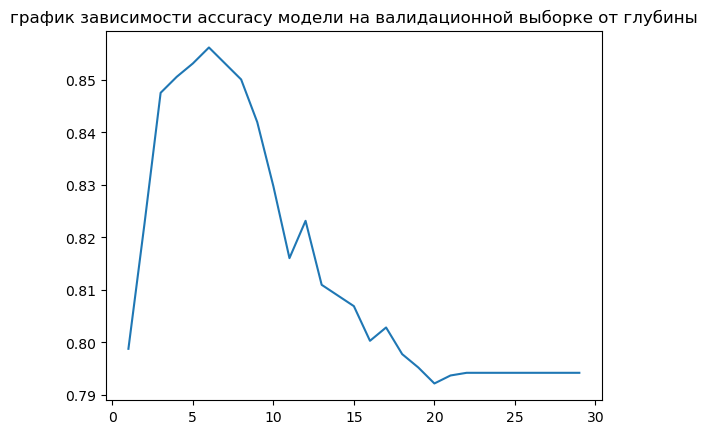

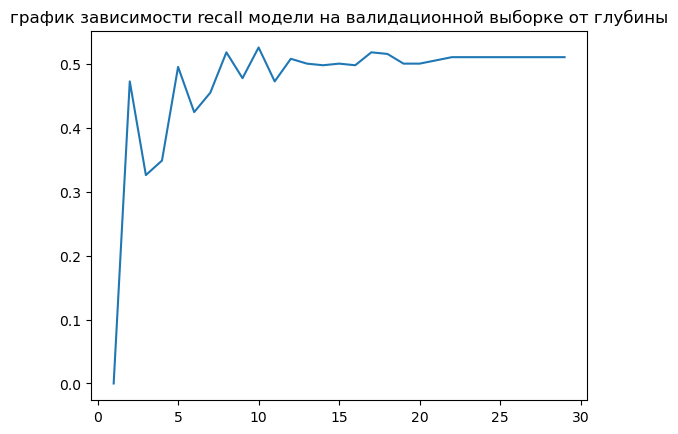

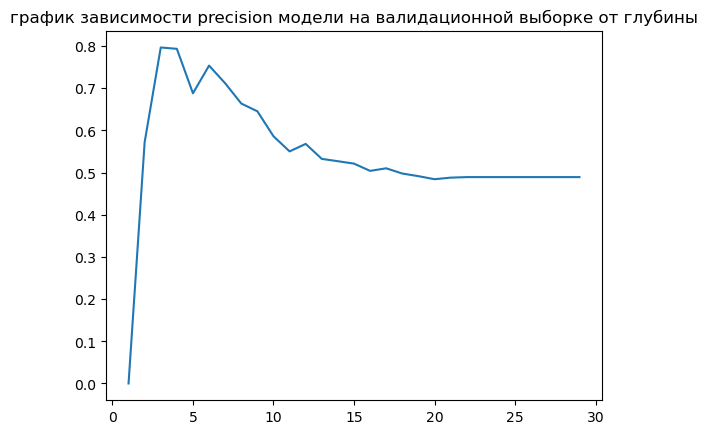

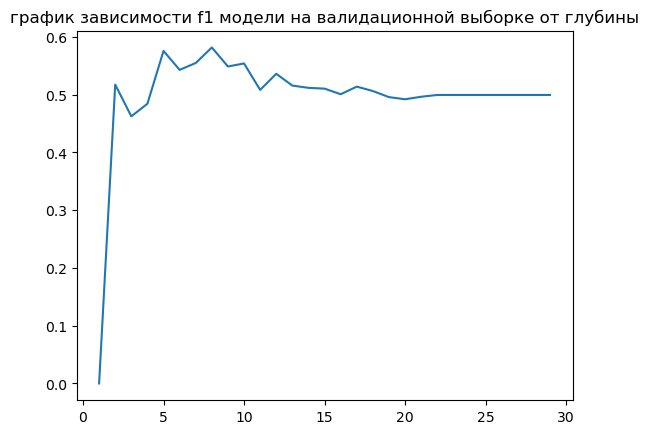

In [20]:
#посмотрим разную глубину для деревьев

warnings.filterwarnings("ignore")

best_model = None
best_f1 = 0
best_depth = 0
accuracy_for_plot = []
recall_for_plot = []
precision_for_plot = []
f1_for_plot = []

depth_for_plot = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    accuracy = model.score(features_valid,target_valid) #качество модели на валидационной выборке
    recall = recall_score(target_valid, predictions)
    precision = precision_score(target_valid, predictions)
    f1 = f1_score(target_valid, predictions)
    
    accuracy_for_plot.append(accuracy)
    depth_for_plot.append(depth)
    recall_for_plot.append(recall)
    precision_for_plot.append(precision)
    f1_for_plot.append(f1)
    
    
    if f1 > best_f1:
        best_model = model # сохраняем наилучшую модель
        best_f1 = f1 #  сохраняем наилучшее значение f1 меры на вал данных
        best_depth = depth

print("F1 наилучшей модели на валидационной выборке:", best_f1,  "Лучшая глубина:", best_depth)


plt.plot(depth_for_plot, accuracy_for_plot)
plt.title('график зависимости accuracy модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, recall_for_plot)
plt.title('график зависимости recall модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, precision_for_plot)
plt.title('график зависимости precision модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, f1_for_plot)
plt.title('график зависимости f1 модели на валидационной выборке от глубины')
plt.show()

### Дерево решений с поиском порога без балансировки

In [21]:
model = DecisionTreeClassifier(random_state=12345, max_depth=8)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 0.6, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))



Порог = 0.00 | Точность = 0.227, Полнота = 0.937, f1 = 0.365 
Порог = 0.05 | Точность = 0.303, Полнота = 0.841, f1 = 0.446 
Порог = 0.10 | Точность = 0.374, Полнота = 0.808, f1 = 0.512 
Порог = 0.15 | Точность = 0.401, Полнота = 0.775, f1 = 0.528 
Порог = 0.20 | Точность = 0.458, Полнота = 0.735, f1 = 0.565 
Порог = 0.25 | Точность = 0.541, Полнота = 0.652, f1 = 0.591 
Порог = 0.30 | Точность = 0.579, Полнота = 0.614, f1 = 0.596 
Порог = 0.35 | Точность = 0.591, Полнота = 0.614, f1 = 0.602 
Порог = 0.40 | Точность = 0.643, Полнота = 0.563, f1 = 0.600 
Порог = 0.45 | Точность = 0.643, Полнота = 0.563, f1 = 0.600 
Порог = 0.50 | Точность = 0.663, Полнота = 0.518, f1 = 0.582 
Порог = 0.55 | Точность = 0.689, Полнота = 0.470, f1 = 0.559 


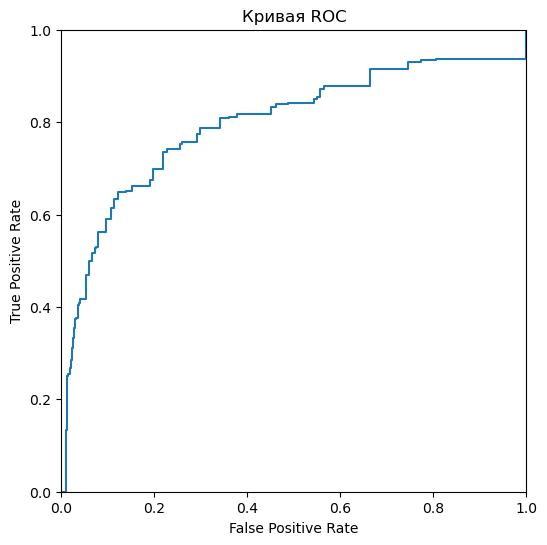

0.8100622959878685


In [22]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

### Поиск лучшей модели случайного леса без балансировки

In [23]:
%%time 
#посмотрим разные варианты деревьев и глубины

warnings.filterwarnings("ignore") 

best_model = 0
best_f1 = 0
best_depth = 0
best_est = 0


for est in range(50, 201, 10): #for est in tqdm(range(50, 2001, 10)):
    for depth in range (4, 16):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучаем модель с заданным количеством деревьев
        model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
        predictions = model.predict(features_valid)
        
        accuracy = model.score(features_valid,target_valid) #качество модели на валидационной выборке
        recall = recall_score(target_valid, predictions)
        precision = precision_score(target_valid, predictions)
        f1 = f1_score(target_valid, predictions)
        
        
        if f1 > best_f1:
            best_model = model # сохраняем наилучшую модель
            best_f1 = f1 #  сохраняем наилучшее значение f1 меры на вал данных
            best_depth = depth
            best_est = est
            best_accuracy =accuracy
            best_recall = recall
            best_precision = precision
            
    
    
    
    
print("Лучшая модель на валидационной выборке:") 
print('Глубина', best_depth )
print('Количество деревьев:', best_est)
print('Значение f1', best_f1)
print('accuracy', best_accuracy)
print('recall', best_recall)
print('precision', best_precision)

Лучшая модель на валидационной выборке:
Глубина 13
Количество деревьев: 110
Значение f1 0.5760000000000001
accuracy 0.8653455284552846
recall 0.45454545454545453
precision 0.7860262008733624
Wall time: 3min 7s


### Случайный лес с поиском порога без балансировки

In [24]:
model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=15) # обучаем модель с заданным количеством деревьев
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 0.6, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))


Порог = 0.00 | Точность = 0.202, Полнота = 1.000, f1 = 0.336 
Порог = 0.05 | Точность = 0.285, Полнота = 0.944, f1 = 0.437 
Порог = 0.10 | Точность = 0.351, Полнота = 0.899, f1 = 0.505 
Порог = 0.15 | Точность = 0.406, Полнота = 0.826, f1 = 0.544 
Порог = 0.20 | Точность = 0.463, Полнота = 0.753, f1 = 0.573 
Порог = 0.25 | Точность = 0.534, Полнота = 0.705, f1 = 0.608 
Порог = 0.30 | Точность = 0.574, Полнота = 0.636, f1 = 0.604 
Порог = 0.35 | Точность = 0.643, Полнота = 0.591, f1 = 0.616 
Порог = 0.40 | Точность = 0.697, Полнота = 0.553, f1 = 0.617 
Порог = 0.45 | Точность = 0.731, Полнота = 0.495, f1 = 0.590 
Порог = 0.50 | Точность = 0.761, Полнота = 0.442, f1 = 0.559 
Порог = 0.55 | Точность = 0.795, Полнота = 0.412, f1 = 0.542 


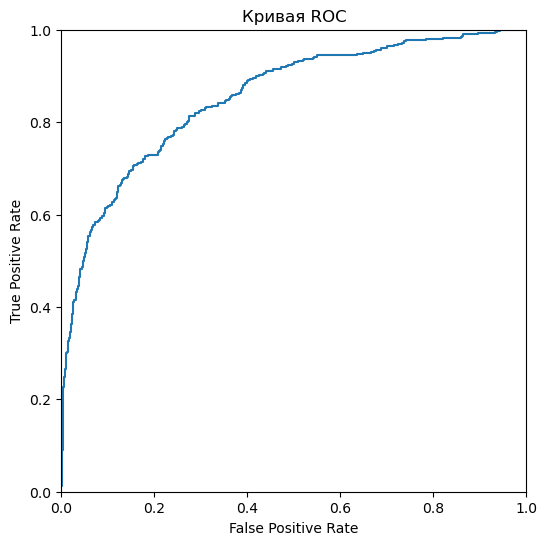

0.8543337317192279

In [25]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

### Логистическая регрессия с поиском лучшего порога без балансировки

In [26]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 0.6, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.201, Полнота = 1.000, f1 = 0.335 
Порог = 0.05 | Точность = 0.226, Полнота = 0.972, f1 = 0.366 
Порог = 0.10 | Точность = 0.267, Полнота = 0.874, f1 = 0.409 
Порог = 0.15 | Точность = 0.324, Полнота = 0.778, f1 = 0.457 
Порог = 0.20 | Точность = 0.384, Полнота = 0.679, f1 = 0.490 
Порог = 0.25 | Точность = 0.436, Полнота = 0.593, f1 = 0.503 
Порог = 0.30 | Точность = 0.495, Полнота = 0.520, f1 = 0.507 
Порог = 0.35 | Точность = 0.539, Полнота = 0.432, f1 = 0.480 
Порог = 0.40 | Точность = 0.552, Полнота = 0.348, f1 = 0.427 
Порог = 0.45 | Точность = 0.594, Полнота = 0.288, f1 = 0.388 
Порог = 0.50 | Точность = 0.632, Полнота = 0.242, f1 = 0.350 
Порог = 0.55 | Точность = 0.695, Полнота = 0.184, f1 = 0.291 


In [27]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_f1 = 0
#перебор значений порога
for threshold in np.arange(0, 0.5, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        
print("Порог = {:.2f} | f1 = {:.3f} ".format(best_threshold, best_f1))

Порог = 0.30 | f1 = 0.507 


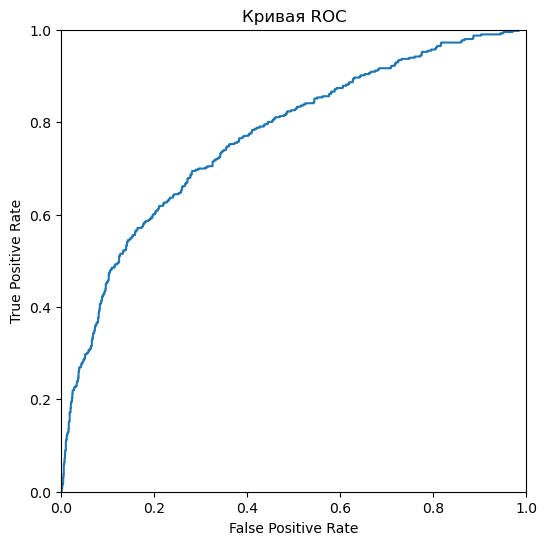

0.7661105328090062

In [28]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()


#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

## Борьба с дисбалансом

Попробуем сначала уравновесить классы, а потом применим методы увеличения и уменьшения выборки

### Поиск лучшего дерева решений с учетом балансировки

F1 наилучшей модели на валидационной выборке: 0.5957873620862588 Лучшая глубина: 6


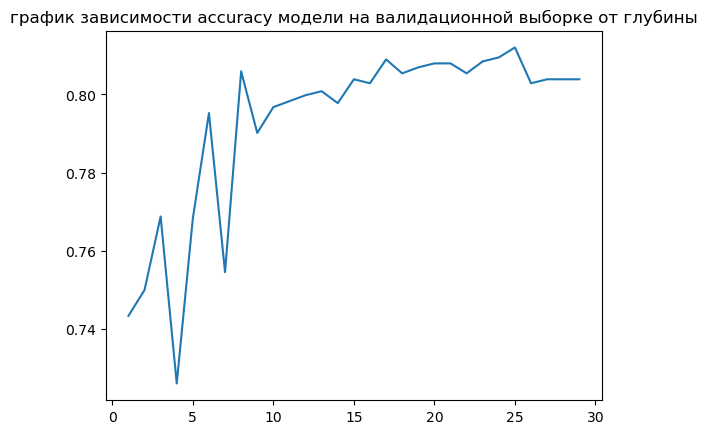

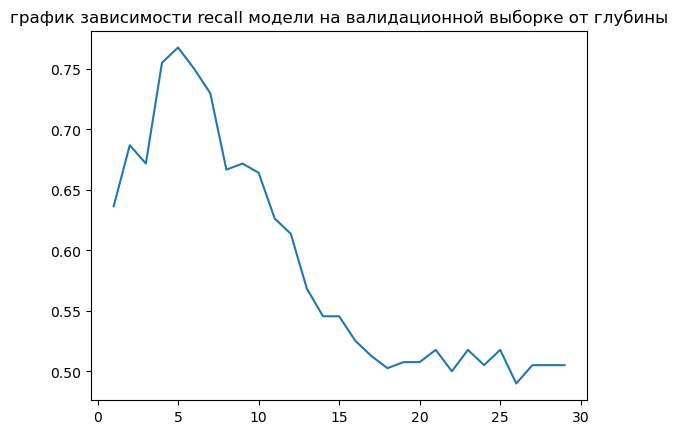

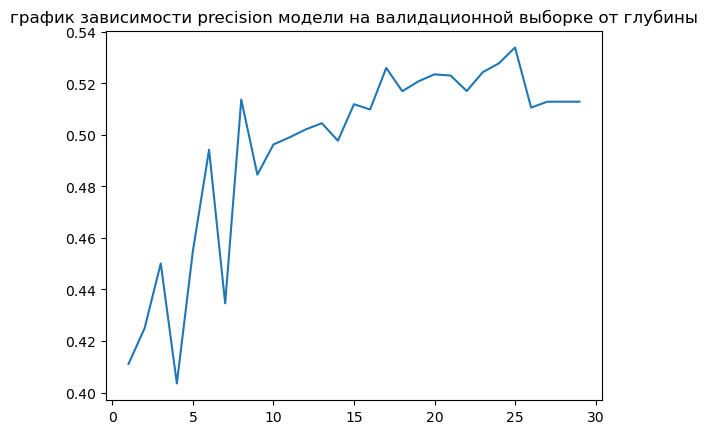

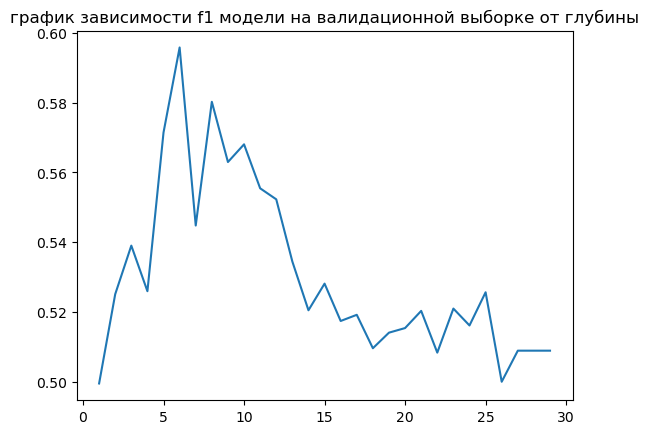

In [29]:
#посмотрим разную глубину для деревьев

warnings.filterwarnings("ignore")

best_model = None
best_f1 = 0
best_depth = 0
accuracy_for_plot = []
recall_for_plot = []
precision_for_plot = []
f1_for_plot = []

depth_for_plot = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth,  class_weight='balanced')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    accuracy = model.score(features_valid,target_valid) #качество модели на валидационной выборке
    recall = recall_score(target_valid, predictions)
    precision = precision_score(target_valid, predictions)
    f1 = f1_score(target_valid, predictions)
    
    accuracy_for_plot.append(accuracy)
    depth_for_plot.append(depth)
    recall_for_plot.append(recall)
    precision_for_plot.append(precision)
    f1_for_plot.append(f1)
    
    
    if f1 > best_f1:
        best_model = model # сохраняем наилучшую модель
        best_f1 = f1 #  сохраняем наилучшее значение f1 меры на вал данных
        best_depth = depth

print("F1 наилучшей модели на валидационной выборке:", best_f1,  "Лучшая глубина:", best_depth)


plt.plot(depth_for_plot, accuracy_for_plot)
plt.title('график зависимости accuracy модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, recall_for_plot)
plt.title('график зависимости recall модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, precision_for_plot)
plt.title('график зависимости precision модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, f1_for_plot)
plt.title('график зависимости f1 модели на валидационной выборке от глубины')
plt.show()

### Дерево решений с поиском порога c учётом балансировки

In [30]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6, class_weight='balanced')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 0.9, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))



Порог = 0.00 | Точность = 0.218, Полнота = 0.965, f1 = 0.356 
Порог = 0.05 | Точность = 0.218, Полнота = 0.965, f1 = 0.356 
Порог = 0.10 | Точность = 0.243, Полнота = 0.939, f1 = 0.387 
Порог = 0.15 | Точность = 0.266, Полнота = 0.889, f1 = 0.409 
Порог = 0.20 | Точность = 0.304, Полнота = 0.861, f1 = 0.450 
Порог = 0.25 | Точность = 0.340, Полнота = 0.841, f1 = 0.484 
Порог = 0.30 | Точность = 0.346, Полнота = 0.831, f1 = 0.488 
Порог = 0.35 | Точность = 0.410, Полнота = 0.793, f1 = 0.540 
Порог = 0.40 | Точность = 0.410, Полнота = 0.793, f1 = 0.540 
Порог = 0.45 | Точность = 0.425, Полнота = 0.793, f1 = 0.554 
Порог = 0.50 | Точность = 0.494, Полнота = 0.750, f1 = 0.596 
Порог = 0.55 | Точность = 0.494, Полнота = 0.750, f1 = 0.596 
Порог = 0.60 | Точность = 0.519, Полнота = 0.697, f1 = 0.595 
Порог = 0.65 | Точность = 0.581, Полнота = 0.573, f1 = 0.577 
Порог = 0.70 | Точность = 0.753, Полнота = 0.462, f1 = 0.573 
Порог = 0.75 | Точность = 0.753, Полнота = 0.462, f1 = 0.573 
Порог = 

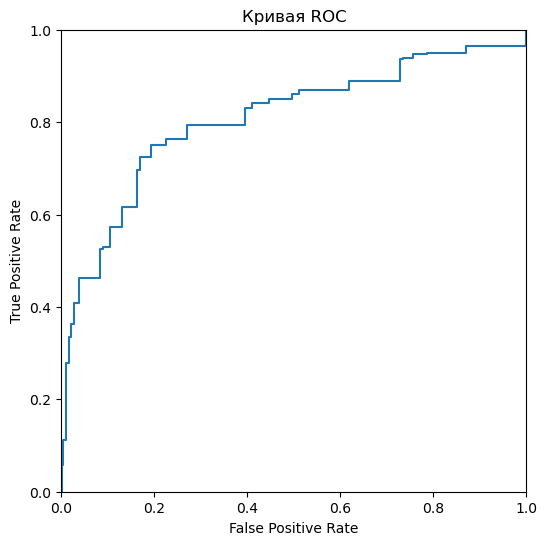

0.8210934086411187

In [31]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

### Поиск лучшей модели случайного леса с учётом балансировки

In [32]:
%%time 
#посмотрим разные варианты деревьев и глубины

warnings.filterwarnings("ignore") 

best_model = 0
best_f1 = 0
best_depth = 0
best_est = 0


for est in range(50, 201, 10): #for est in tqdm(range(50, 201, 10)):
    for depth in range (4, 16):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth,  class_weight='balanced') # обучаем модель с заданным количеством деревьев
        model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
        predictions = model.predict(features_valid)
        
        accuracy = model.score(features_valid,target_valid) #качество модели на валидационной выборке
        recall = recall_score(target_valid, predictions)
        precision = precision_score(target_valid, predictions)
        f1 = f1_score(target_valid, predictions)
        
        
        if f1 > best_f1:
            best_model = model # сохраняем наилучшую модель
            best_f1 = f1 #  сохраняем наилучшее значение f1 меры на вал данных
            best_depth = depth
            best_est = est
            best_accuracy =accuracy
            best_recall = recall
            best_precision = precision
            
    
    
    
    
print("Лучшая модель на валидационной выборке:") 
print('Глубина', best_depth )
print('Количество деревьев:', best_est)
print('Значение f1', best_f1)
print('accuracy', best_accuracy)
print('recall', best_recall)
print('precision', best_precision)

Лучшая модель на валидационной выборке:
Глубина 9
Количество деревьев: 200
Значение f1 0.644311377245509
accuracy 0.8490853658536586
recall 0.6792929292929293
precision 0.6127562642369021
Wall time: 2min 14s


### Случайный лес с поиском порога с учётом балансировки

In [33]:
model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=12,  class_weight='balanced') # обучаем модель с заданным количеством деревьев
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))


Порог = 0.00 | Точность = 0.201, Полнота = 1.000, f1 = 0.335 
Порог = 0.05 | Точность = 0.240, Полнота = 0.980, f1 = 0.385 
Порог = 0.10 | Точность = 0.283, Полнота = 0.942, f1 = 0.435 
Порог = 0.15 | Точность = 0.328, Полнота = 0.884, f1 = 0.478 
Порог = 0.20 | Точность = 0.384, Полнота = 0.848, f1 = 0.528 
Порог = 0.25 | Точность = 0.442, Полнота = 0.813, f1 = 0.573 
Порог = 0.30 | Точность = 0.476, Полнота = 0.758, f1 = 0.585 
Порог = 0.35 | Точность = 0.533, Полнота = 0.715, f1 = 0.611 
Порог = 0.40 | Точность = 0.595, Полнота = 0.662, f1 = 0.627 
Порог = 0.45 | Точность = 0.638, Полнота = 0.629, f1 = 0.634 
Порог = 0.50 | Точность = 0.680, Полнота = 0.563, f1 = 0.616 
Порог = 0.55 | Точность = 0.711, Полнота = 0.497, f1 = 0.585 
Порог = 0.60 | Точность = 0.739, Полнота = 0.449, f1 = 0.559 
Порог = 0.65 | Точность = 0.756, Полнота = 0.369, f1 = 0.496 
Порог = 0.70 | Точность = 0.806, Полнота = 0.326, f1 = 0.464 
Порог = 0.75 | Точность = 0.837, Полнота = 0.273, f1 = 0.411 
Порог = 

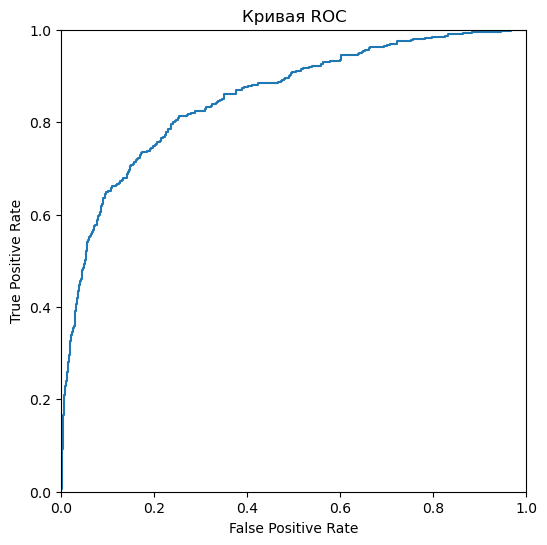

0.8535755134037578

In [34]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()


#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

### Логистическая регрессия с поиском лучшего порога с учётом балансировки

In [35]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000,  class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.201, Полнота = 1.000, f1 = 0.335 
Порог = 0.05 | Точность = 0.202, Полнота = 1.000, f1 = 0.335 
Порог = 0.10 | Точность = 0.206, Полнота = 0.995, f1 = 0.342 
Порог = 0.15 | Точность = 0.220, Полнота = 0.980, f1 = 0.360 
Порог = 0.20 | Точность = 0.235, Полнота = 0.952, f1 = 0.376 
Порог = 0.25 | Точность = 0.250, Полнота = 0.917, f1 = 0.393 
Порог = 0.30 | Точность = 0.273, Полнота = 0.891, f1 = 0.418 
Порог = 0.35 | Точность = 0.297, Полнота = 0.846, f1 = 0.440 
Порог = 0.40 | Точность = 0.327, Полнота = 0.785, f1 = 0.462 
Порог = 0.45 | Точность = 0.358, Полнота = 0.727, f1 = 0.480 
Порог = 0.50 | Точность = 0.395, Полнота = 0.674, f1 = 0.498 
Порог = 0.55 | Точность = 0.423, Полнота = 0.616, f1 = 0.502 
Порог = 0.60 | Точность = 0.466, Полнота = 0.558, f1 = 0.508 
Порог = 0.65 | Точность = 0.520, Полнота = 0.500, f1 = 0.510 
Порог = 0.70 | Точность = 0.535, Полнота = 0.409, f1 = 0.464 
Порог = 0.75 | Точность = 0.559, Полнота = 0.311, f1 = 0.399 
Порог = 

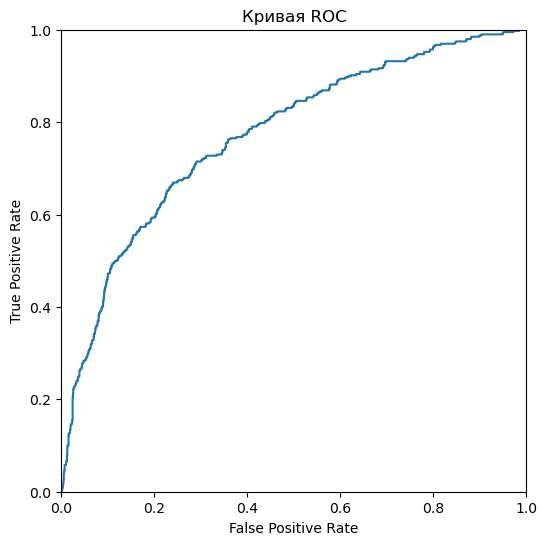

0.7703819364124707

In [36]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

### Балансировка классов с помощью техник увеличения и уменьшения выборки

In [37]:
#посмотрим во сколько раз отличаются размеры таргетов

print(target_train[target_train == 1.0].count()/target_train[target_train == 0.0].count()) 

0.25164299342802626


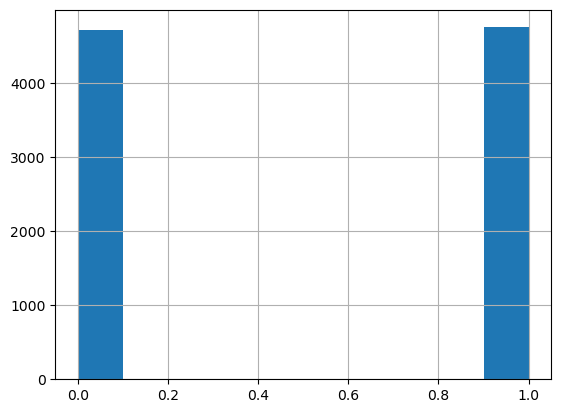

In [38]:
#функция увеличения кооличества положительных признаков в тренировочной выборке
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled


#применим функцию 
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)


target_train_upsampled.hist()
plt.show()



<div class="alert alert-block alert-success">
<b>Успех👍 В2:</b> 
    
Лучше не стоит прямо в притык все ровнять, ведь нам не нужно, чтобы модель училась в "идеальных условиях"
</div>

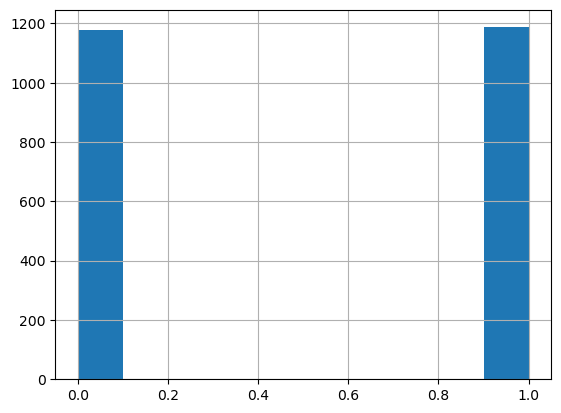

In [39]:
#функция уменьшения кооличества отрицательных признаков в тренировочной выборке
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled




features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

target_train_downsampled.hist()
plt.show()

### Поиск лучшего дерева решений с учетом увеличения выборки

F1 наилучшей модели на валидационной выборке: 0.5909547738693467 Лучшая глубина: 6


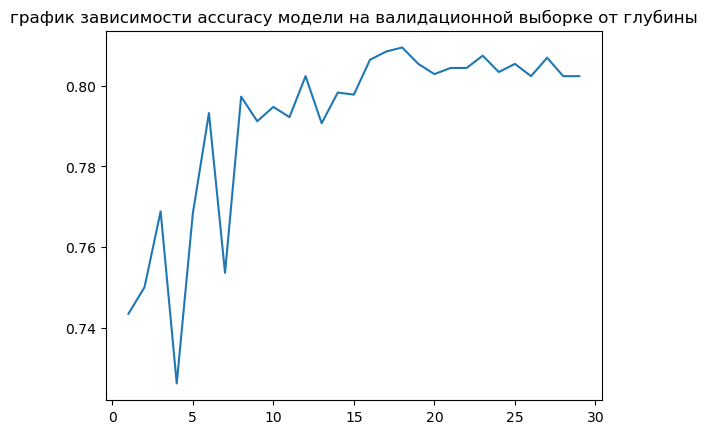

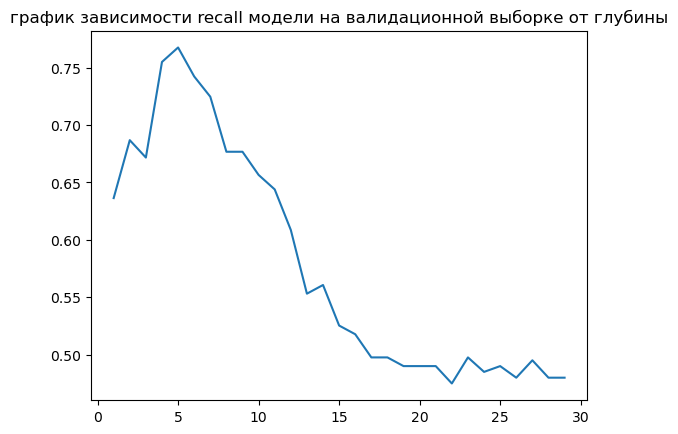

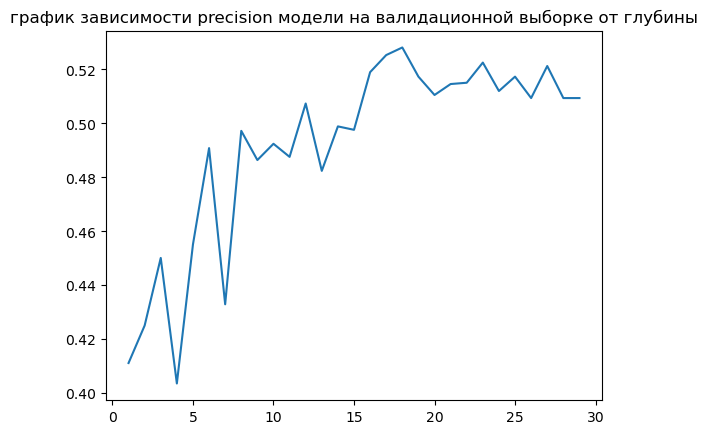

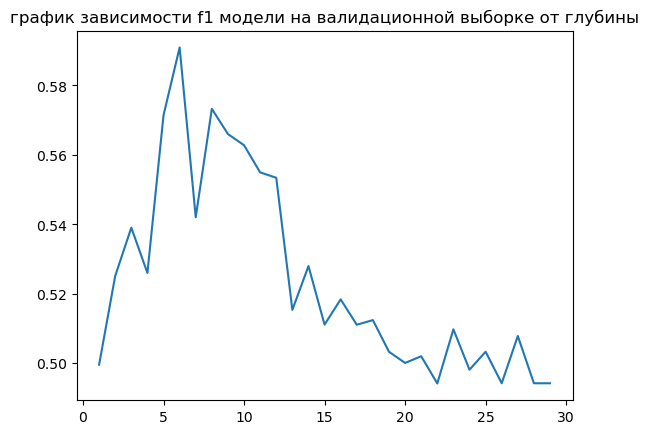

In [40]:
#посмотрим разную глубину для деревьев

warnings.filterwarnings("ignore")

best_model = None
best_f1 = 0
best_depth = 0
accuracy_for_plot = []
recall_for_plot = []
precision_for_plot = []
f1_for_plot = []

depth_for_plot = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train_upsampled, target_train_upsampled)
    predictions = model.predict(features_valid)
    
    accuracy = model.score(features_valid,target_valid) #качество модели на валидационной выборке
    recall = recall_score(target_valid, predictions)
    precision = precision_score(target_valid, predictions)
    f1 = f1_score(target_valid, predictions)
    
    accuracy_for_plot.append(accuracy)
    depth_for_plot.append(depth)
    recall_for_plot.append(recall)
    precision_for_plot.append(precision)
    f1_for_plot.append(f1)
    
    
    if f1 > best_f1:
        best_model = model # сохраняем наилучшую модель
        best_f1 = f1 #  сохраняем наилучшее значение f1 меры на вал данных
        best_depth = depth

print("F1 наилучшей модели на валидационной выборке:", best_f1,  "Лучшая глубина:", best_depth)


plt.plot(depth_for_plot, accuracy_for_plot)
plt.title('график зависимости accuracy модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, recall_for_plot)
plt.title('график зависимости recall модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, precision_for_plot)
plt.title('график зависимости precision модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, f1_for_plot)
plt.title('график зависимости f1 модели на валидационной выборке от глубины')
plt.show()

### Дерево решений с поиском порога с учётом увеличения выборки

In [41]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7)
model.fit(features_train_upsampled, target_train_upsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 1, 0.1):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))



Порог = 0.00 | Точность = 0.222, Полнота = 0.937, f1 = 0.359 
Порог = 0.10 | Точность = 0.254, Полнота = 0.902, f1 = 0.397 
Порог = 0.20 | Точность = 0.317, Полнота = 0.838, f1 = 0.460 
Порог = 0.30 | Точность = 0.320, Полнота = 0.818, f1 = 0.460 
Порог = 0.40 | Точность = 0.401, Полнота = 0.773, f1 = 0.528 
Порог = 0.50 | Точность = 0.433, Полнота = 0.725, f1 = 0.542 
Порог = 0.60 | Точность = 0.600, Полнота = 0.646, f1 = 0.622 
Порог = 0.70 | Точность = 0.635, Полнота = 0.619, f1 = 0.627 
Порог = 0.80 | Точность = 0.719, Полнота = 0.510, f1 = 0.597 
Порог = 0.90 | Точность = 0.818, Полнота = 0.351, f1 = 0.491 


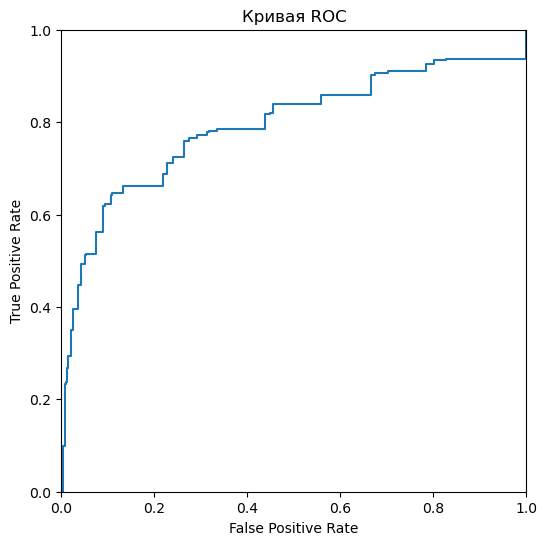

0.8076888477651837

In [42]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

### Поиск лучшего дерева решений с учетом уменьшения выборки

F1 наилучшей модели на валидационной выборке: 0.5705882352941177 Лучшая глубина: 6


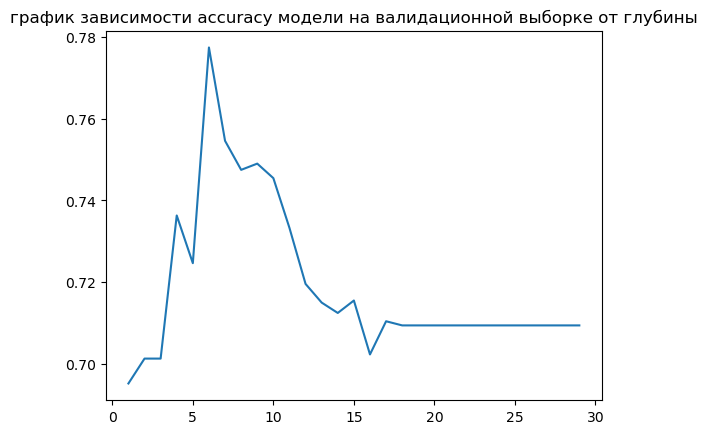

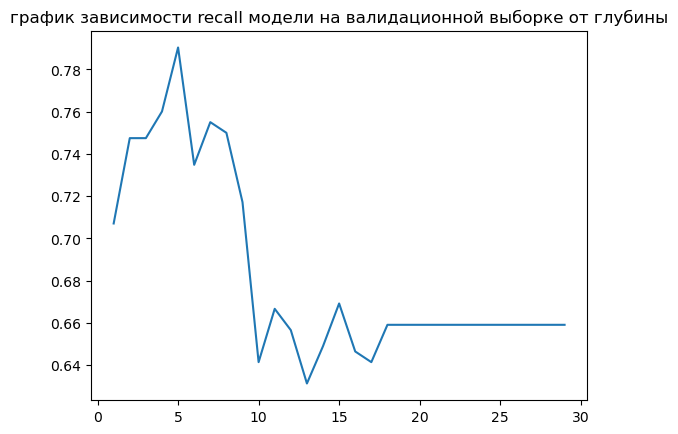

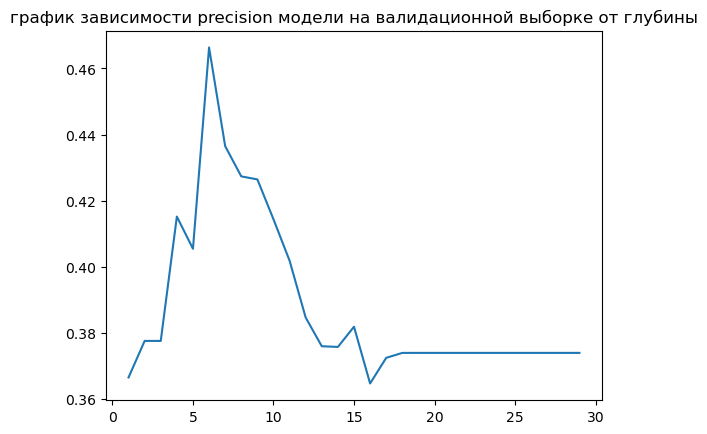

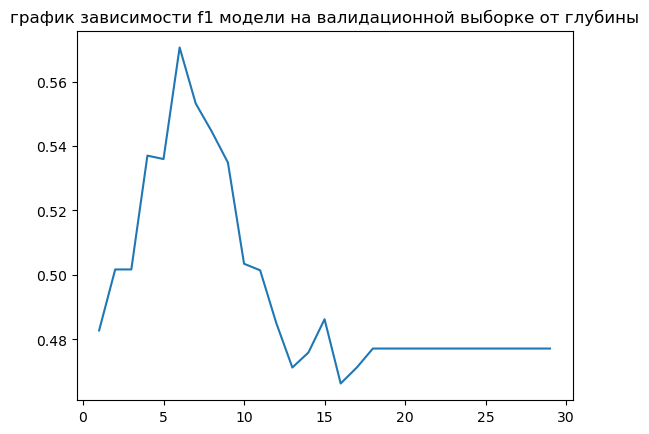

In [43]:
#посмотрим разную глубину для деревьев

warnings.filterwarnings("ignore")

best_model = None
best_f1 = 0
best_depth = 0
accuracy_for_plot = []
recall_for_plot = []
precision_for_plot = []
f1_for_plot = []

depth_for_plot = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train_downsampled, target_train_downsampled)
    predictions = model.predict(features_valid)
    
    accuracy = model.score(features_valid,target_valid) #качество модели на валидационной выборке
    recall = recall_score(target_valid, predictions)
    precision = precision_score(target_valid, predictions)
    f1 = f1_score(target_valid, predictions)
    
    accuracy_for_plot.append(accuracy)
    depth_for_plot.append(depth)
    recall_for_plot.append(recall)
    precision_for_plot.append(precision)
    f1_for_plot.append(f1)
    
    
    if f1 > best_f1:
        best_model = model # сохраняем наилучшую модель
        best_f1 = f1 #  сохраняем наилучшее значение f1 меры на вал данных
        best_depth = depth

print("F1 наилучшей модели на валидационной выборке:", best_f1,  "Лучшая глубина:", best_depth)


plt.plot(depth_for_plot, accuracy_for_plot)
plt.title('график зависимости accuracy модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, recall_for_plot)
plt.title('график зависимости recall модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, precision_for_plot)
plt.title('график зависимости precision модели на валидационной выборке от глубины')
plt.show()

plt.plot(depth_for_plot, f1_for_plot)
plt.title('график зависимости f1 модели на валидационной выборке от глубины')
plt.show()

### Дерево решений с поиском порога с учётом уменьшения выборки

In [44]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_train_downsampled, target_train_downsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 1, 0.1):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))



Порог = 0.00 | Точность = 0.202, Полнота = 0.992, f1 = 0.336 
Порог = 0.10 | Точность = 0.244, Полнота = 0.967, f1 = 0.389 
Порог = 0.20 | Точность = 0.294, Полнота = 0.879, f1 = 0.441 
Порог = 0.30 | Точность = 0.327, Полнота = 0.859, f1 = 0.473 
Порог = 0.40 | Точность = 0.393, Полнота = 0.811, f1 = 0.529 
Порог = 0.50 | Точность = 0.466, Полнота = 0.735, f1 = 0.571 
Порог = 0.60 | Точность = 0.466, Полнота = 0.735, f1 = 0.571 
Порог = 0.70 | Точность = 0.565, Полнота = 0.548, f1 = 0.556 
Порог = 0.80 | Точность = 0.690, Полнота = 0.422, f1 = 0.524 
Порог = 0.90 | Точность = 0.763, Полнота = 0.253, f1 = 0.380 


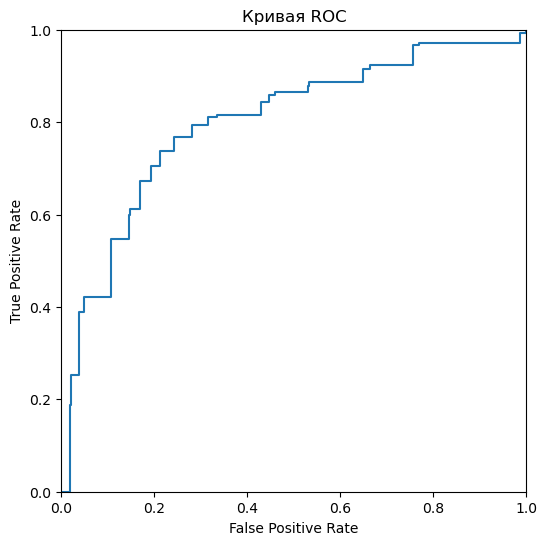

0.8176115480504793

In [45]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

### Поиск лучшей модели случайного леса с учётом увеличения выборки

In [46]:
%%time 
#посмотрим разные варианты деревьев и глубины

warnings.filterwarnings("ignore") 

best_model = 0
best_f1 = 0
best_depth = 0
best_est = 0


for est in range(50, 201, 10): #for est in tqdm(range(1, 51, 1)):
    for depth in range (4, 16):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучаем модель с заданным количеством деревьев
        model.fit(features_train_upsampled, target_train_upsampled) # обучаем модель на тренировочной выборке
        predictions = model.predict(features_valid)
        
        accuracy = model.score(features_valid,target_valid) #качество модели на валидационной выборке
        recall = recall_score(target_valid, predictions)
        precision = precision_score(target_valid, predictions)
        f1 = f1_score(target_valid, predictions)
        
        
        if f1 > best_f1:
            best_model = model # сохраняем наилучшую модель
            best_f1 = f1 #  сохраняем наилучшее значение f1 меры на вал данных
            best_depth = depth
            best_est = est
            best_accuracy =accuracy
            best_recall = recall
            best_precision = precision
            
    
    
    
    
print("Лучшая модель на валидационной выборке:") 
print('Глубина', best_depth )
print('Количество деревьев:', best_est)
print('Значение f1', best_f1)
print('accuracy', best_accuracy)
print('recall', best_recall)
print('precision', best_precision)

Лучшая модель на валидационной выборке:
Глубина 13
Количество деревьев: 100
Значение f1 0.6419437340153453
accuracy 0.8577235772357723
recall 0.6338383838383839
precision 0.6502590673575129
Wall time: 2min 44s


### Случайный лес с учётом увеличения выборки

In [47]:
model = RandomForestClassifier(random_state=12345, n_estimators=190, max_depth=15) # обучаем модель с заданным количеством деревьев
model.fit(features_train_upsampled, target_train_upsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))


Порог = 0.00 | Точность = 0.201, Полнота = 1.000, f1 = 0.335 
Порог = 0.05 | Точность = 0.254, Полнота = 0.980, f1 = 0.404 
Порог = 0.10 | Точность = 0.297, Полнота = 0.927, f1 = 0.449 
Порог = 0.15 | Точность = 0.345, Полнота = 0.899, f1 = 0.499 
Порог = 0.20 | Точность = 0.394, Полнота = 0.859, f1 = 0.540 
Порог = 0.25 | Точность = 0.426, Полнота = 0.818, f1 = 0.561 
Порог = 0.30 | Точность = 0.462, Полнота = 0.755, f1 = 0.573 
Порог = 0.35 | Точность = 0.510, Полнота = 0.722, f1 = 0.598 
Порог = 0.40 | Точность = 0.577, Полнота = 0.684, f1 = 0.626 
Порог = 0.45 | Точность = 0.638, Полнота = 0.646, f1 = 0.642 
Порог = 0.50 | Точность = 0.657, Полнота = 0.581, f1 = 0.617 
Порог = 0.55 | Точность = 0.688, Полнота = 0.545, f1 = 0.608 
Порог = 0.60 | Точность = 0.725, Полнота = 0.492, f1 = 0.586 
Порог = 0.65 | Точность = 0.748, Полнота = 0.419, f1 = 0.537 
Порог = 0.70 | Точность = 0.793, Полнота = 0.369, f1 = 0.503 
Порог = 0.75 | Точность = 0.839, Полнота = 0.328, f1 = 0.472 
Порог = 

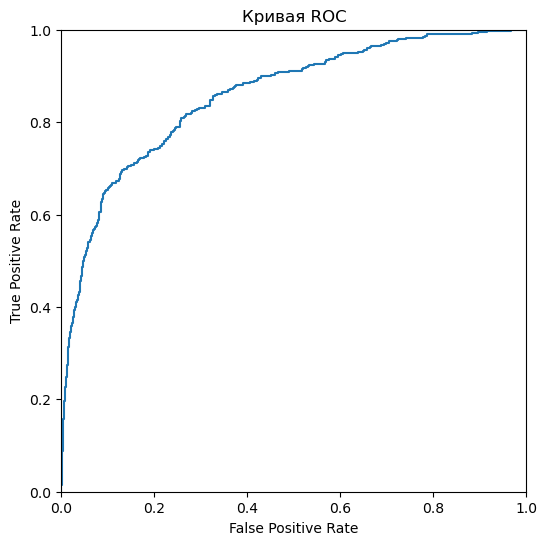

0.8573023491916623

In [48]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

### Поиск лучшей модели случайного леса с учётом уменьшения выборки

In [49]:
%%time 
#посмотрим разные варианты деревьев и глубины

warnings.filterwarnings("ignore") 

best_model = 0
best_f1 = 0
best_depth = 0
best_est = 0


for est in range(50, 201, 10): #for est in tqdm(range(1, 51, 1)):
    for depth in range (4, 16):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучаем модель с заданным количеством деревьев
        model.fit(features_train_downsampled, target_train_downsampled) # обучаем модель на тренировочной выборке
        predictions = model.predict(features_valid)
        
        accuracy = model.score(features_valid,target_valid) #качество модели на валидационной выборке
        recall = recall_score(target_valid, predictions)
        precision = precision_score(target_valid, predictions)
        f1 = f1_score(target_valid, predictions)
        
        
        if f1 > best_f1:
            best_model = model # сохраняем наилучшую модель
            best_f1 = f1 #  сохраняем наилучшее значение f1 меры на вал данных
            best_depth = depth
            best_est = est
            best_accuracy =accuracy
            best_recall = recall
            best_precision = precision
            
    
    
    
    
print("Лучшая модель на валидационной выборке:") 
print('Глубина', best_depth )
print('Количество деревьев:', best_est)
print('Значение f1', best_f1)
print('accuracy', best_accuracy)
print('recall', best_recall)
print('precision', best_precision)

Лучшая модель на валидационной выборке:
Глубина 12
Количество деревьев: 90
Значение f1 0.603585657370518
accuracy 0.7977642276422764
recall 0.7651515151515151
precision 0.49835526315789475
Wall time: 1min 18s


### Случайный лес с учётом уменьшения выборки

In [50]:
model = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth=9) # обучаем модель с заданным количеством деревьев
model.fit(features_train_downsampled, target_train_downsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))


Порог = 0.00 | Точность = 0.201, Полнота = 1.000, f1 = 0.335 
Порог = 0.05 | Точность = 0.207, Полнота = 1.000, f1 = 0.343 
Порог = 0.10 | Точность = 0.229, Полнота = 0.987, f1 = 0.371 
Порог = 0.15 | Точность = 0.246, Полнота = 0.980, f1 = 0.393 
Порог = 0.20 | Точность = 0.265, Полнота = 0.965, f1 = 0.416 
Порог = 0.25 | Точность = 0.292, Полнота = 0.949, f1 = 0.447 
Порог = 0.30 | Точность = 0.319, Полнота = 0.907, f1 = 0.472 
Порог = 0.35 | Точность = 0.354, Полнота = 0.886, f1 = 0.506 
Порог = 0.40 | Точность = 0.398, Полнота = 0.838, f1 = 0.539 
Порог = 0.45 | Точность = 0.443, Полнота = 0.798, f1 = 0.570 
Порог = 0.50 | Точность = 0.485, Полнота = 0.750, f1 = 0.589 
Порог = 0.55 | Точность = 0.548, Полнота = 0.710, f1 = 0.618 
Порог = 0.60 | Точность = 0.598, Полнота = 0.654, f1 = 0.625 
Порог = 0.65 | Точность = 0.656, Полнота = 0.596, f1 = 0.624 
Порог = 0.70 | Точность = 0.708, Полнота = 0.545, f1 = 0.616 
Порог = 0.75 | Точность = 0.733, Полнота = 0.449, f1 = 0.557 
Порог = 

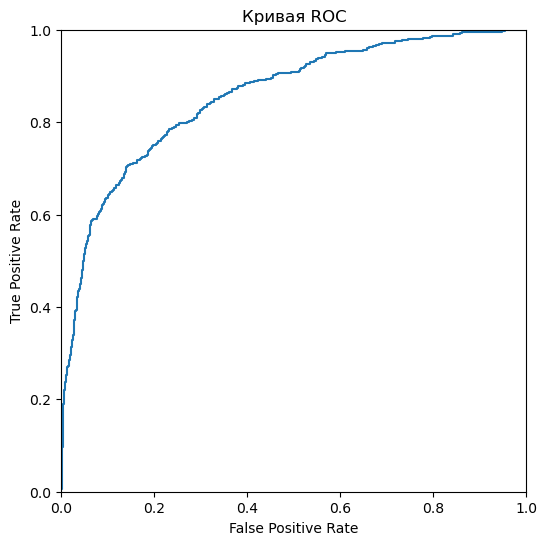

0.8566999511656002

In [51]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

### Логистическая регрессия с учётом увеличения выборки

In [52]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train_upsampled, target_train_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.201, Полнота = 1.000, f1 = 0.335 
Порог = 0.05 | Точность = 0.202, Полнота = 1.000, f1 = 0.335 
Порог = 0.10 | Точность = 0.206, Полнота = 0.995, f1 = 0.341 
Порог = 0.15 | Точность = 0.220, Полнота = 0.980, f1 = 0.359 
Порог = 0.20 | Точность = 0.235, Полнота = 0.952, f1 = 0.376 
Порог = 0.25 | Точность = 0.251, Полнота = 0.919, f1 = 0.394 
Порог = 0.30 | Точность = 0.273, Полнота = 0.894, f1 = 0.418 
Порог = 0.35 | Точность = 0.296, Полнота = 0.846, f1 = 0.438 
Порог = 0.40 | Точность = 0.327, Полнота = 0.790, f1 = 0.462 
Порог = 0.45 | Точность = 0.355, Полнота = 0.727, f1 = 0.477 
Порог = 0.50 | Точность = 0.395, Полнота = 0.677, f1 = 0.499 
Порог = 0.55 | Точность = 0.423, Полнота = 0.621, f1 = 0.504 
Порог = 0.60 | Точность = 0.465, Полнота = 0.561, f1 = 0.509 
Порог = 0.65 | Точность = 0.517, Полнота = 0.500, f1 = 0.508 
Порог = 0.70 | Точность = 0.534, Полнота = 0.412, f1 = 0.465 
Порог = 0.75 | Точность = 0.554, Полнота = 0.311, f1 = 0.398 
Порог = 

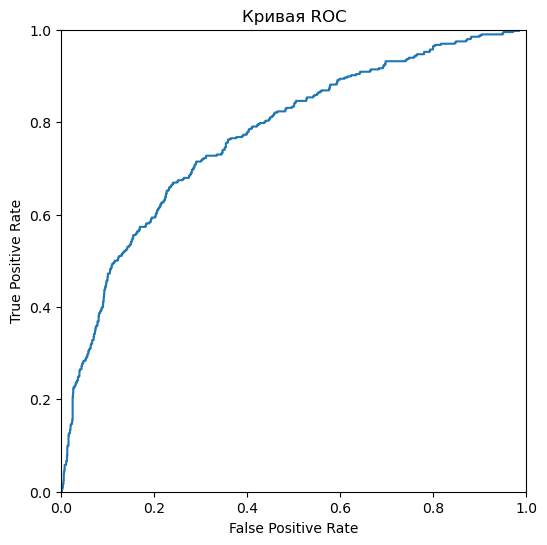

0.7703706916493176

In [53]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

### Логистическая регрессия с учётом уменьшения выборки

In [54]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train_downsampled, target_train_downsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

#перебор значений порога
for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.201, Полнота = 1.000, f1 = 0.335 
Порог = 0.05 | Точность = 0.202, Полнота = 1.000, f1 = 0.336 
Порог = 0.10 | Точность = 0.206, Полнота = 0.995, f1 = 0.341 
Порог = 0.15 | Точность = 0.220, Полнота = 0.980, f1 = 0.359 
Порог = 0.20 | Точность = 0.232, Полнота = 0.949, f1 = 0.373 
Порог = 0.25 | Точность = 0.249, Полнота = 0.922, f1 = 0.392 
Порог = 0.30 | Точность = 0.272, Полнота = 0.896, f1 = 0.417 
Порог = 0.35 | Точность = 0.293, Полнота = 0.846, f1 = 0.436 
Порог = 0.40 | Точность = 0.322, Полнота = 0.785, f1 = 0.457 
Порог = 0.45 | Точность = 0.358, Полнота = 0.732, f1 = 0.481 
Порог = 0.50 | Точность = 0.397, Полнота = 0.687, f1 = 0.503 
Порог = 0.55 | Точность = 0.424, Полнота = 0.629, f1 = 0.507 
Порог = 0.60 | Точность = 0.466, Полнота = 0.551, f1 = 0.505 
Порог = 0.65 | Точность = 0.520, Полнота = 0.495, f1 = 0.507 
Порог = 0.70 | Точность = 0.546, Полнота = 0.402, f1 = 0.463 
Порог = 0.75 | Точность = 0.563, Полнота = 0.306, f1 = 0.396 
Порог = 

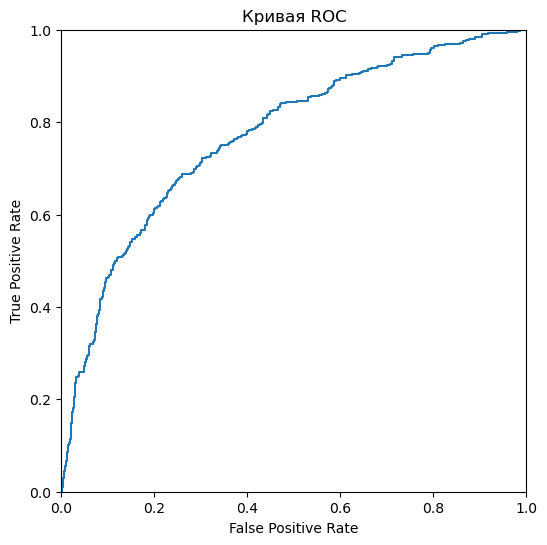

0.7712188680700132

In [55]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

#значение auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

## Выводы по анализу 

Для сравнительного анализа приведу три таблицы с разными моделями: дерево решений, случайный лес и логистическая регрессия. Модели были построены без учета дисбаланса и с учетом с различными способами его устранения.


| Модель | Глубина | f1 | Наилучший порог, f1 | auc-roc |
| --- | --- | --- | --- | --- |
| Дерево решений без балансировки | 8 | 0.581 | Порог = 0.35 | f1 = 0.602 | 0.810 |
| Дерево решений взвешенное | 6 | 0.595 | Порог = 0.55 | f1 = 0.596 | 0.821 |
| Дерево решений с увел. выборкой | 6 | 0.590 | Порог = 0.70 | f1 = 0.627 | 0.807 |
| Дерево решений с умен. выборкой | 6 | 0.570 | Порог = 0.50 | f1 = 0.571 | 0.817 |







| Модель | Кол-во деревьев | Глубина | f1  | Наилучший порог |  F1 | auc-roc |
| --- | --- | --- | --- | --- | --- | --- |
| Лес без балансировки | 110 | 13 | 0.576 | 0.40  | 0.617 | 0.854 |
| Лес взвешенный | 200 | 9 |  0.644 | 0.45 | 0.634 | 0.853 |
| Лес с ув. выборкой | 100 | 13 | 0.641 | 0.45  | 0.642 | 0.857 |
| Лес с ум. выборкой | 90 | 12 |  0.603 | 0.60  | 0.625 | 0.856 |








| Модель | Наилучший порог  | f1 | auc-roc |
| --- | --- | --- | --- |
| Лог рег без балансировки | 0.30 | 0.507 | 0.766 |
| Лог рег взвешенная | 0.65  | 0.510 | 0.770 |
| Лог рег с ув. выборкой | 0.60  | 0.509 | 0.770 |
| Лог рег с ум. выборкой | 0.55 | 0.507 | 0.771 |




**Наилучшей моделью оказалась модель случайного леса с увеличенной выборкой с количеством деревьев равным 100, глубиной 13. При пороге 0.45 метрика f1 равняется 0.642, а значение auc-roc 0.857 на валидационных данных**





## Тестирование модели

Протестируем модель на наилучшей модели.

In [60]:
#случайный лес с увеличенной выборкой
model = RandomForestClassifier(random_state=12345, n_estimators=190, max_depth=15) # обучаем модель с заданным количеством деревьев
model.fit(features_train_upsampled, target_train_upsampled)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]


predicted_test = probabilities_one_test > 0.45
precision = precision_score(target_test, predicted_test)
recall = recall_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)

print("Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f} ".format(precision, recall, f1))

Точность = 0.588, Полнота = 0.592, f1 = 0.590 


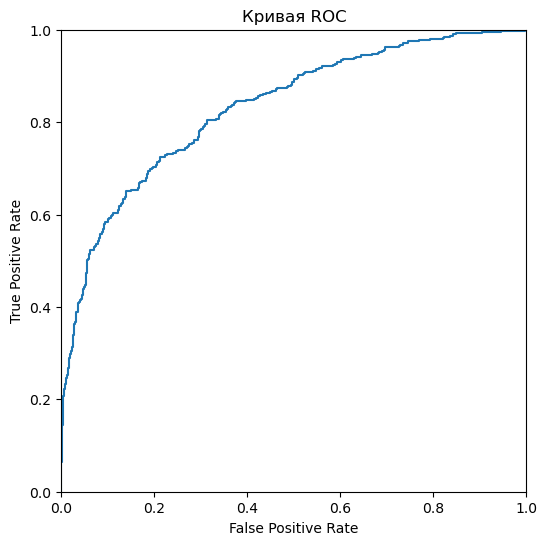

0.8313051735376246

In [61]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

#значение auc_roc
auc_roc = roc_auc_score(target_test, probabilities_one_test)
auc_roc

## Общие выводы

Данная работа была посвящена анализу оттока клиентов юанка. Задачей было найти модель, которая бы предсказывала, уйдёт клиент или нет.

**Подготовка данных** 

Исходные данные представляли собой датасет с данными, примерно 10000 строк. В одном столбце Тenure(сколько лет человек клиент банка) были обнаружены пропуски. Часть пропусков была заполнена медианным значением величины относительно каждого возраста. Пропуски в редковстречаемых категориях возраста были удалены, пропуски составили 160 строк, в результате чего количество элементов было сокращено с 10000 до 9840. 

Данные были проверены на выбросы и аномальные значения. Также данные были проверены на первичные корреляции с помощью матрицы корреляций. В данных был обнаружен дисбаланс классов.

Для дальнейшего построения моделей машинного обучения данные были разделены на обучающую, валидационную и тренировочную выборки в отношении 60/20/20. Далее данные были подвержены порядковому кодированию для корректной работы алгоритмов с категориальными данными. Таким образом категориальные данные были превпащены в количественные. 

Далее данные были стандартизированны для корректного обучения моделей.

**Исследование задачи**

Поскольку в данных был обнаружен дисбаланс классов, было принято решение попробовать 4 варианта данных: 

1) данные с дисбалансом без балансировки

2) данные с взвешенными классами

3) данные с увеличенной выборкой

4) данные с уменьшенной выборкой

Для каждого варианта были построены 3 модели машинного обучения, а именно модели дерева решений, случайного леса и логистической регрессии.В работе приведена сравнительная табличка результатов для каждой модели.

Таким образом лучшей моделью стал случайный лес с увеличенной выборкой с количеством деревьев равным 100, глубиной 13. При пороге 0.45 метрика f1 равняется 0.642, а значение auc-roc 0.857 на валидационных данных. Далее было принято решение тестировать именно эту модель

**Тестирование модели**

Модель случайного леса показала следующие результаты на тестовых данных: 

Порог = 0.45 

Точность = 0.588, 

Полнота = 0.592, 

f1 = 0.590 

auc-roc = 0.831

_________________________________________________________




**Результаты и рекомендации**

Для поднятия качества необходимо увеличить собранную статистику и попробовать новые методы машинного обучения. По факту полученная точность близка к случайной.